In [1]:
from scipy import *
from numpy import *
from matplotlib.pyplot import *
from scipy.linalg import *
from numpy.linalg import *
from scipy.integrate import solve_ivp
import FNC

In [2]:
# This (optional) block is for improving the display of plots.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg","pdf")
rcParams["figure.figsize"] = [7,4]
rcParams["lines.linewidth"] = 2
rcParams["lines.markersize"] = 4
rcParams['animation.html'] = "jshtml"  # or try "html5"

# Example 10.1.2

We'll examine the guessing/IVP approach for the case $\lambda=0.6$. 

In [3]:
lamb = 0.6
phi = lambda r,w,dwdr: lamb/w**2 - dwdr/r

We have to avoid $r=0$, or we would divide by zero.

In [4]:
a = 2**-52 
b = 1

We convert the ODE to a first-order system in $v_1$, $v_2$. 

In [5]:
f = lambda r,v: hstack( [ v[1], phi(r,v[0],v[1]) ] )

Now we try multiple guesses for the unknown $w(0)$ and plot the solutions. 

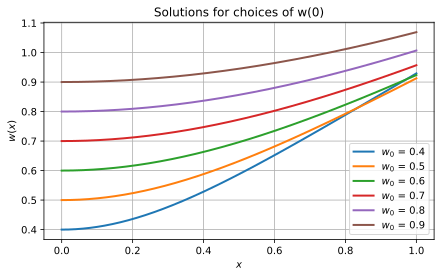

In [6]:
t = linspace(a,b,400)
for w0 in arange(0.4,1.,0.1):
    sol = solve_ivp(f,[a,b],[w0,0],t_eval=t)
    plot(t,sol.y[0],label=f"$w_0$ = {w0:.1f}")
    
legend(); xlabel("$x$"); ylabel("$w(x)$"); 
grid(True);
title("Solutions for choices of w(0)");

On the graph, it's the curve starting at $w(0)=0.8$ that comes closest to the required condition $w(1)=1$. 

# Example 10.1.3

We eliminate the guesswork for $w(0)$ and let `shoot` do the work for us.

In [7]:
lamb = 0.6
phi = lambda r,w,dwdr: lamb/w**2 - dwdr/r;
a,b = 2**-52,1

We specify the given and unknown endpoint values.

In [8]:
lval,lder = [],[0]    # w(a)=?, w'(a)=0
rval,rder = [1],[]    # w(b)=1, w'(b)=?

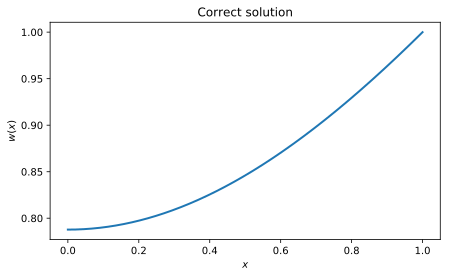

In [9]:
r,w,dwdx = FNC.shoot(phi,(a,b),lval,lder,rval,rder,0.8)
plot(r,w);
title("Correct solution");
xlabel("$x$"); ylabel("$w(x)$");

The value of $w$ at $r=1$, meant to be exactly one, was computed to be

In [10]:
print("right end value:",w[-1])

right end value: 1.0000000221506224


The accuracy is consistent with the error tolerance used for the IVP solution by `shoot`. The initial value $w(0)$ that gave this solution is

In [11]:
print("left end value:",w[0])

left end value: 0.787757854056847


# Example 10.1.4

We compute shooting solutions for several values of $\lambda$.

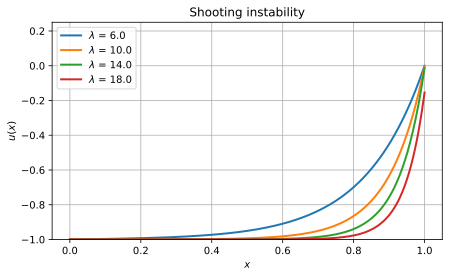

In [12]:
lval,rval = [-1], [0]
for lamb in range(6,22,4):
    phi = lambda x,u,dudx: lamb**2*u + lamb**2
    x,u,dudx = FNC.shoot(phi,[0.0,1.0],lval,[],rval,[],0.0)
    plot(x,u,label=f"$\lambda$ = {lamb:.1f}")

xlabel("$x$"); ylabel("$u(x)$"); ylim(-1.,0.25); grid(True)
legend(loc="upper left"); title("Shooting instability");

The solutions are inaccurate near the right endpoint as $\lambda$ increases.

# Example 10.2.1

We test first-order and second-order differentiation matrices for the function $x + e^{\sin 4x}$ over $[-1,1]$. 

In [13]:
f = lambda x: x + exp(sin(4*x))

For reference, here are the exact first and second derivatives.

In [14]:
dfdx = lambda x: 1 + 4*exp(sin(4*x))*cos(4*x)
d2fdx2 = lambda x: 4*exp(sin(4*x))*(4*cos(4*x)**2-4*sin(4*x))

We discretize on equally spaced nodes and evaluate $f$ at the nodes. 

In [15]:
t,Dx,Dxx = FNC.diffmat2(12,[-1,1])
y = f(t)

Then the first two derivatives of $f$ each require one matrix-vector multiplication.

In [16]:
yx = Dx@y
yxx = Dxx@y

The results are fair but not very accurate for this small value of $n$. 

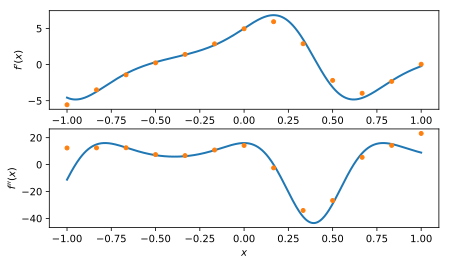

In [17]:
x = linspace(-1,1,500)
subplot(2,1,1)
plot(x,dfdx(x))
xlabel("$x$");  ylabel("$f'(x)$");
plot(t,yx,"o")

subplot(2,1,2)
plot(x,d2fdx2(x))
xlabel("$x$");  ylabel("$f''(x)$");
plot(t,yxx,"o");

An experiment confirms the order of accuracy.

In [18]:
N = array( [int(2**k) for k in arange(4,11.5,.5)] )
err1 = zeros(len(N))
err2 = zeros(len(N))
print("   n    error f'    error f''")
for (k,n) in enumerate(N):
    t,Dx,Dxx = FNC.diffmat2(n,[-1,1])
    y = f(t)
    err1[k] = norm( dfdx(t) - Dx@y, Inf )
    err2[k] = norm( d2fdx2(t) - Dxx@y, Inf )
    print(f"{n:4d}  {err1[k]:10.2e}  {err2[k]:10.2e}")

   n    error f'    error f''
  16    7.55e-01    1.67e+01
  22    4.94e-01    9.88e+00
  32    2.70e-01    4.63e+00
  45    1.48e-01    2.16e+00
  64    7.65e-02    9.51e-01
  90    3.97e-02    4.26e-01
 128    2.00e-02    1.88e-01
 181    1.01e-02    8.49e-02
 256    5.08e-03    3.91e-02
 362    2.55e-03    1.83e-02
 512    1.28e-03    8.70e-03
 724    6.42e-04    4.19e-03
1024    3.21e-04    2.03e-03
1448    1.61e-04    9.97e-04
2048    8.05e-05    4.91e-04


For $O(n^{-p})$ convergence, we use a log-log plot of the errors. 

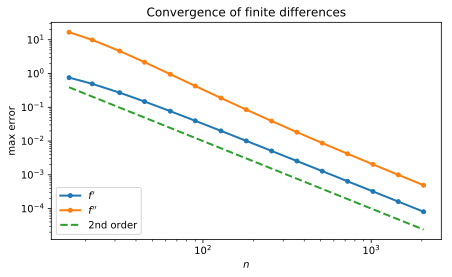

In [19]:
loglog(N,err1,"-o",label="$f'$")
loglog(N,err2,"-o",label="$f''$")
plot(N,10*10/N**2,"--",label="2nd order")
xlabel("$n$"), ylabel("max error");
legend(loc="lower left"); 
title("Convergence of finite differences");

# Example 10.2.2

Here is a $4\times 4$ Chebyshev differentiation matrix.

In [20]:
t,Dx,Dxx = FNC.diffcheb(3,[-1,1])
Dx

array([[-3.16666667,  4.        , -1.33333333,  0.5       ],
       [-1.        ,  0.33333333,  1.        , -0.33333333],
       [ 0.33333333, -1.        , -0.33333333,  1.        ],
       [-0.5       ,  1.33333333, -4.        ,  3.16666667]])

We again test the convergence rate.  

In [21]:
f = lambda x: x + exp(sin(4*x))
dfdx = lambda x: 1 + 4*exp(sin(4*x))*cos(4*x)
d2fdx2 = lambda x: 4*exp(sin(4*x))*(4*cos(4*x)**2-4*sin(4*x))

N = range(5,75,5)
err1 = zeros(len(N))
err2 = zeros(len(N))
print("   n    error f'    error f''")
for (k,n) in enumerate(N):
    t,Dx,Dxx = FNC.diffcheb(n,[-1,1])
    y = f(t)
    err1[k] = norm( dfdx(t) - Dx@y, Inf )
    err2[k] = norm( d2fdx2(t) - Dxx@y, Inf )
    print(f"{n:4d}  {err1[k]:10.2e}  {err2[k]:10.2e}")

   n    error f'    error f''
   5    2.80e+00    4.65e+01
  10    7.49e-01    3.46e+01
  15    8.70e-02    1.05e+01
  20    6.57e-03    1.60e+00
  25    3.87e-04    1.61e-01
  30    2.02e-05    1.21e-02
  35    8.79e-07    7.17e-04
  40    3.28e-08    3.50e-05
  45    1.06e-09    1.43e-06
  50    3.02e-11    5.03e-08
  55    9.28e-13    1.98e-09
  60    4.36e-13    2.94e-10
  65    5.50e-13    5.58e-10
  70    4.67e-13    8.12e-10


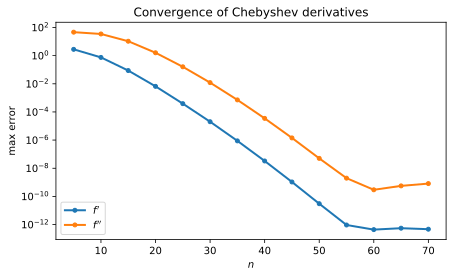

In [22]:
semilogy(N,err1,"-o",label="$f'$")
semilogy(N,err2,"-o",label="$f''$")
xlabel("$n$"), ylabel("max error");
legend(loc="lower left"); title("Convergence of Chebyshev derivatives");

Notice that the graph has a log-linear scale, not log-log. Hence the convergence is exponential, as we expect for a spectral method on a smooth function. 

# Example 10.3.1

Consider the linear BVP  $$ u'' - (\cos x) u' + (\sin x) u = 0, \quad 0 \le x \le \pi/2, \quad u(0)=1, \; u(\pi/2)=e. $$ Its exact solution is simple.

In [23]:
exact = lambda x: exp(sin(x))

The problem is presented in our standard form, so we can identify the coefficient functions in the ODE. Each should be coded so that they can accept either scalar or vector inputs.

In [24]:
p = lambda x: -cos(x)
q = sin
r = lambda x: 0*x        # function, not value 

We solve the BVP and compare the result to the exact solution.

In [25]:
x,u = FNC.bvplin(p,q,r,[0,pi/2],1,exp(1),25)

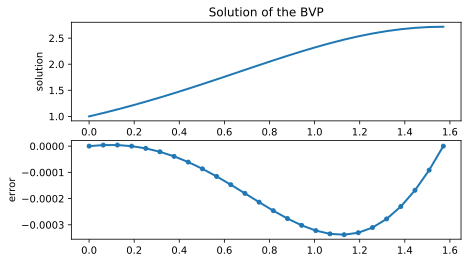

In [26]:
subplot(2,1,1)
plot(x,u)
ylabel("solution");
title("Solution of the BVP");

subplot(2,1,2)
plot(x,exact(x)-u,"-o")
ylabel("error");

# Example 10.3.2

In [27]:
lamb = 10
exact = lambda x: sinh(lamb*x)/sinh(lamb) - 1

These functions define the ODE.

In [28]:
p = lambda x: 0*x
q = lambda x: -lamb**2*ones(len(x))
r = lambda x: lamb**2*ones(len(x))

We compare the computed solution to the exact one for increasing $n$. 

In [29]:
N = array([32,64,128,256,512])
err = zeros(len(N))
print("  n      error")
for k,n in enumerate(N):
    x,u = FNC.bvplin(p,q,r,[0,1],-1,0,n)    
    err[k] = norm(exact(x)-u,Inf)
    print(f"{n:4d}  {err[k]:10.2e}")

  n      error
  32    1.48e-03
  64    3.73e-04
 128    9.35e-05
 256    2.34e-05
 512    5.85e-06


Each time $n$ is doubled, the error is reduced by a factor very close to 4, which is indicative of second order convergence.

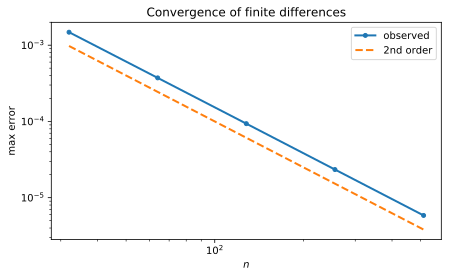

In [30]:
loglog(N,err,"-o",label="observed")
loglog(N,1/N**2,"--",label="2nd order")
xlabel("$n$"); ylabel("max error");
legend(); title("Convergence of finite differences");

# Example 10.4.2

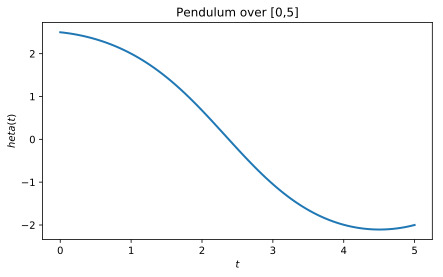

In [31]:
phi = lambda t,theta,omega: -0.05*omega - sin(theta)
init = linspace(2.5,-2,101)

t,theta = FNC.bvp(phi,[0,5],[2.5],[],[-2],[],init)
plot(t,theta)
xlabel("$t$"); ylabel("$\theta(t)$");
title("Pendulum over [0,5]");

Note how the angle decreases throughout the motion until near the end. If we extend the time interval longer, then we find a rather different solution.

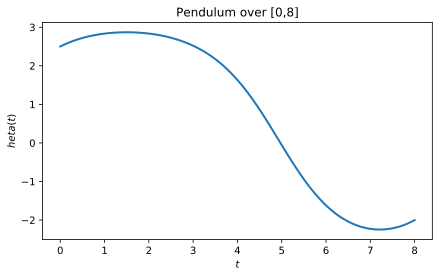

In [32]:
t,theta = FNC.bvp(phi,[0,8],[2.5],[],[-2],[],init)
plot(t,theta)
xlabel("$t$"); ylabel("$\theta(t)$");
title("Pendulum over [0,8]");

This time the angle initially _increases_, and the pendulum hovers near the vertical position before swinging back down. 

# Example 10.4.3

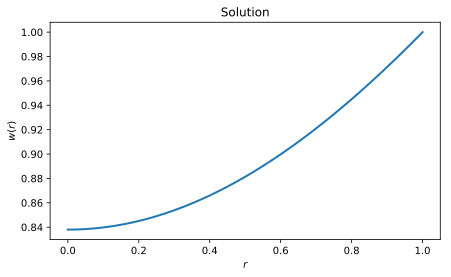

In [33]:
lamb = 0.5
phi = lambda r,w,dwdr: lamb/w**2 - dwdr/r

init = ones(301)
r,w1 = FNC.bvp(phi,[2**-52,1],[],[0],[1],[],init)
plot(r,w1)
fig,ax = gcf(),gca();
xlabel("$r$"); ylabel("$w(r)$"); 
title("Solution");

By choosing a different initial guess, we arrive at another solution.

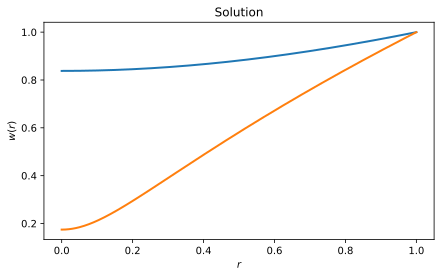

In [34]:
init = 0.5*ones(301)
r,w2 = FNC.bvp(phi,[2**-52,1],[],[0],[1],[],init)
ax.plot(r,w2);
fig

# Example 10.4.4

Finding a solution is easy at some values of $\epsilon$. 

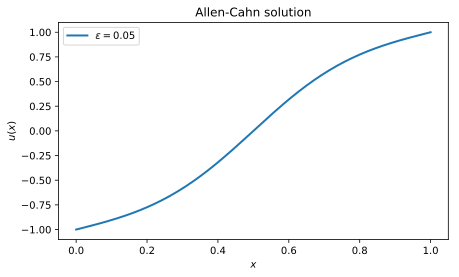

In [35]:
epsilon = 0.05
phi = lambda x,u,dudx: (u**3 - u) / epsilon

init = linspace(-1,1,141)
x,u1 = FNC.bvp(phi,[0,1],[-1],[],[1],[],init)

plot(x,u1,label="$\epsilon = 0.05$")
fig = gcf(); ax = gca();
xlabel("$x$"); ylabel("$u(x)$");
legend(); title("Allen-Cahn solution");

However, finding a good starting guess is not trivial for smaller values of $\epsilon$. Note below that the iteration stops without converging to a solution.

In [36]:
epsilon = 0.005;
x,u = FNC.bvp(phi,[0,1],[-1],[],[1],[],init)

/Users/driscoll/Dropbox/books/fnc-extras/python/FNC04.py:171: UserWarning: Iteration did not find a root.
  warnings.warn("Iteration did not find a root.")


A simple way around this problem is to use the result of a solved version as the starting guess for a more difficult version.

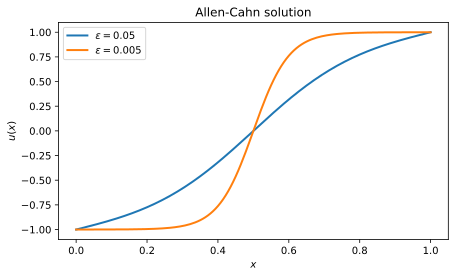

In [37]:
x,u2 = FNC.bvp(phi,[0,1],[-1],[],[1],[],u1)
ax.plot(x,u2,label="$\epsilon = 0.005$")
ax.legend(); fig

In this case we can continue further.

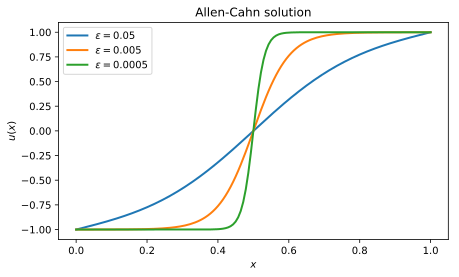

In [38]:
epsilon = 0.0005
x,u3 = FNC.bvp(phi,[0,1],[-1],[],[1],[],u2)
ax.plot(x,u3,label="$\epsilon = 0.0005$")
ax.legend(); fig

# Example 10.5.2

Here are the coefficient functions.

In [39]:
c = lambda x: x**2
q = lambda x: 4*ones(len(x))
f = lambda x: sin(pi*x)

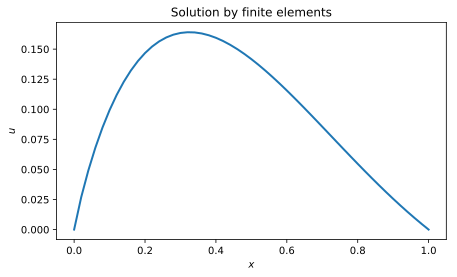

In [40]:
x,u = FNC.fem(c,q,f,0,1,50)
plot(x,u)
xlabel("$x$"); ylabel("$u$"); 
title("Solution by finite elements");